<a href="https://colab.research.google.com/github/grosetta/rdkit_study/blob/main/%E5%AF%B9%E6%8A%97%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#文件头代码
import sys
from google.colab import drive
drive.mount('/content/gdrive')
sys.path.insert(0,"/content/gdrive/My Drive/Colab Notebooks/python_package/")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import os
import time
import glob
import PIL
from PIL import Image
import imageio
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from IPython import display

2.9.2


In [9]:
#图像像素大小
width, height = 28, 28

In [7]:
#数据准备
# 创建项目子目录
def makepath(Subdirectory):
    try:
        os.makedirs(Subdirectory)
    except FileExistsError:
        pass

# 原始图像文件
filepath_list = ["/content/gdrive/My Drive/data/spproved_pic", "/content/gdrive/My Drive/data/approved_128", "/content/gdrive/My Drive/data/training_checkpoints", "./gen_image"]
for filepath in filepath_list:
    makepath(filepath)

In [ ]:
# 获取每个类别的图片文件列表
def get_file_list(filepath, ext_list):
    file_list = []
    for root, dirs, files in os.walk(filepath):
        for file in files:
            if os.path.splitext(file)[1] in ext_list:
                file_list.append(os.path.join(filepath, file))
        return file_list


drugs_file_list = get_file_list(filepath='/content/gdrive/My Drive/data/approved_pic', ext_list=['.jpg'])

In [ ]:
#批量改变图片像素
def imgresize(file_list,savepath, width, height):
    for filepath in file_list:
        print(filepath)
        try:
            im = Image.open(filepath)
            new_im =im.resize((width, height))
            new_im.save(savepath + '/' + str(filepath.split('/')[-1]))
            print('图片: ' + filepath[filepath.rfind('\\')+1:] + ' 像素转换完成')
        except OSError as e:
            print(e.args)

imgresize(file_list=drugs_file_list, savepath="/content/gdrive/My Drive/data/approved_128", width=width, height=height)


drugs_128_file_list = get_file_list(filepath='/content/gdrive/My Drive/data/approved_128', ext_list=['.jpg'])

label = ['药物']*len(drugs_128_file_list)
y = np.array(label)

In [20]:
# 图像转化为张量数组
Pixel_list = []
for filename in drugs_128_file_list:
    img = Image.open(filename)
    # width, height = img.size
    img_L = img.convert("L")
    Core = img_L.getdata()
    img_arr = np.array(Core, dtype='float32') / 255.0
    img_list = img_arr.tolist()
    Pixel_list.extend(img_list)

In [21]:
#像素点值转化为数组
X = np.array(Pixel_list).reshape(len(drugs_128_file_list), width, height)
len(X)

2006

In [23]:
#按照4:1的比例将数据划分训练集和测试集
train_images, test_images, train_labels, test_labels = train_test_split(X, y, test_size=0.02, random_state=0)

train_images = train_images.reshape(train_images.shape[0], width, height, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # 将图片标准化到 [-1, 1] 区间内

BUFFER_SIZE = len(train_images)
BATCH_SIZE = 256

# 批量化和打乱数据
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [24]:
# 生成器使用 tf.keras.layers.Conv2DTranspose （上采样）层来从种子（随机噪声）中产生图片。
# 以一个使用该种子作为输入的 Dense 层开始，
# 然后多次上采样直到达到所期望的 28x28x1 的图片尺寸。注意除了输出层使用 tanh 之外，
# 其他每层均使用 tf.keras.layers.LeakyReLU 作为激活函数。
def make_generator_model():

    model = tf.keras.Sequential()
    model.add(layers.Dense(int(width/4)*int(height/4)*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((int(width/4), int(height/4), 256)))
    assert model.output_shape == (None, int(width/4), int(height/4), 256) # 注意：batch size 没有限制
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, int(width/4), int(width/4), 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, int(width/2), int(width/2), 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, width, height, 1)
    return model

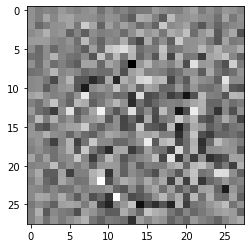

In [25]:
# 使用（尚未训练的）生成器创建一张图片。
generator = make_generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [26]:
# 判别器是一个基于CNN的图片分类器。
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[width, height, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

In [27]:
# 使用（尚未训练的）判别器来对图片的真伪进行判断。模型将被训练为为真实图片输出正值，为伪造图片输出负值。

# 决策边界
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.0035522]], shape=(1, 1), dtype=float32)


In [28]:
# 该方法返回计算交叉熵损失的辅助函数
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [29]:
# 判别器损失
# 该方法量化判别器从判断真伪图片的能力。它将判别器对真实图片的预测值与值全为 1 的数组进行对比，
# 将判别器对伪造（生成的）图片的预测值与值全为 0 的数组进行对比。

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [30]:
# 生成器损失
# 生成器损失量化其欺骗判别器的能力。直观来讲，如果生成器表现良好，判别器将会把伪造图片判断为真实图片（或1）。
# 这里我们将把判别器在生成图片上的判断结果与一个值全为1的数组进行对比。

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [31]:
# 由于我们需要分别训练两个网络，判别器和生成器的优化器是不同的。
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [34]:
# 本笔记还演示了如何保存和恢复模型，这在长时间训练任务被中断的情况下比较有帮助。
checkpoint_dir = '/content/gdrive/My Drive/data/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [40]:
# 我们将重复使用该种子（因此在动画GIF中更容易可视化进度）
EPOCHS=50
num_examples_to_generate = 1
noise_dim = 100
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [36]:
# 训练循环在生成器接收到一个随机种子作为输入时开始。该种子用于生产一张图片。
# 判别器随后被用于区分真实图片（选自训练集）和伪造图片（由生成器生成）。
# 针对这里的每一个模型都计算损失函数，
# 并且计算梯度用于更新生成器与判别器。

# 注意 `tf.function` 的使用
# 该注解使函数被“编译”
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [38]:
# 生成与保存图片
def generate_and_save_images(model, epoch, test_input):
    # 注意 training` 设定为 False
    # 因此，所有层都在推理模式下运行（batchnorm）。
    predictions = model(test_input, training=False)

    plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(1, 1, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.savefig('./{:04d}.png'.format(epoch))

# 训练模型
# 调用上面定义的 train() 方法来同时训练生成器和判别器。注意，训练GANs可能是棘手的。重要的是，
# 生成器和判别器不能够互相压制对方（例如，他们以相似的学习率训练）。
# 在训练之初，生成的图片看起来像是随机噪声。随着训练过程的进行，生成的数字将越来越真实。
# 在大概 50个epoch 之后，这些图片看起来像是MNIST数字。使用Colab中的默认设置可能需要大约
# 1分钟每epoch。

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            train_step(image_batch)
        # 继续进行时为 GIF 生成图像
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        # 每 15 个 epoch 保存一次模型
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # 最后一个 epoch 结束后生成图片
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

CPU times: user 39min 9s, sys: 17.9 s, total: 39min 27s
Wall time: 24min 4s


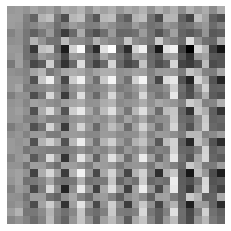

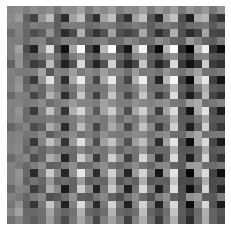

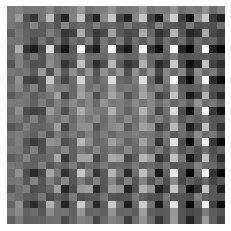

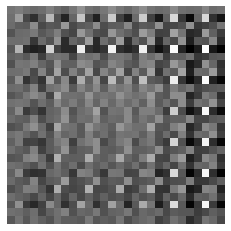

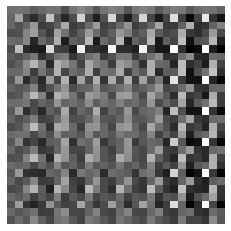

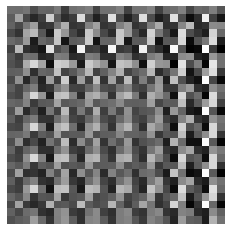

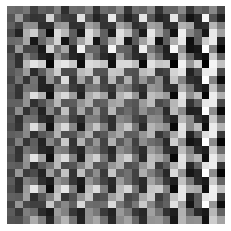

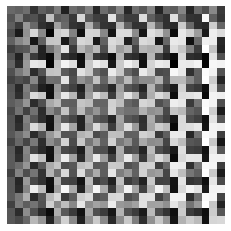

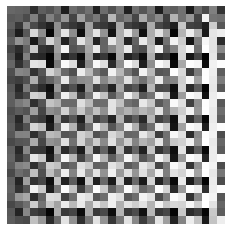

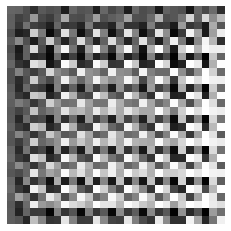

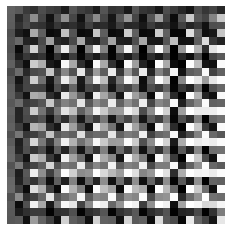

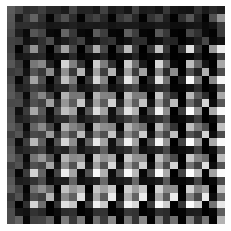

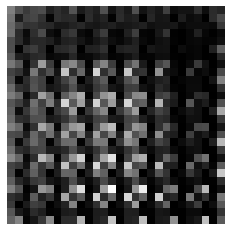

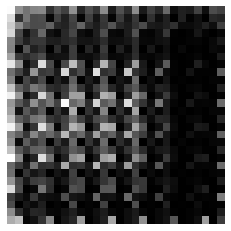

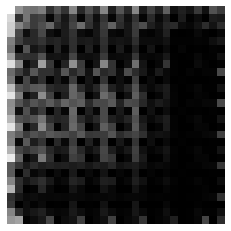

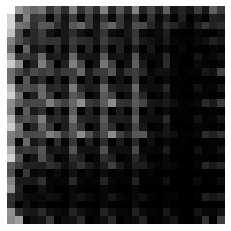

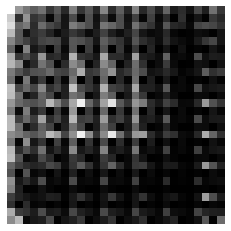

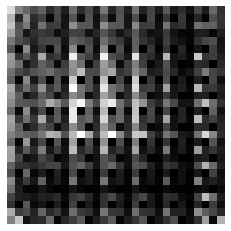

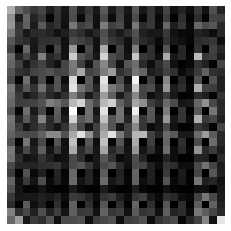

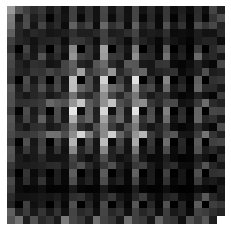

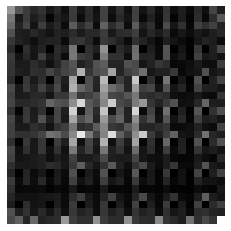

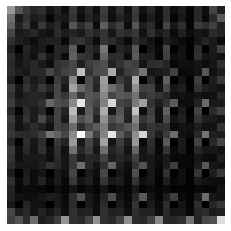

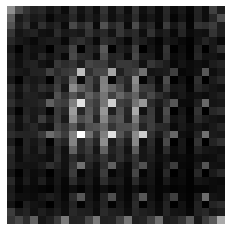

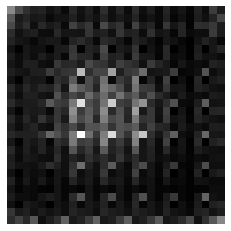

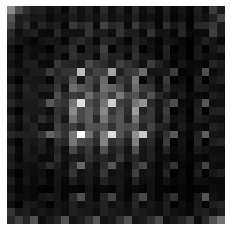

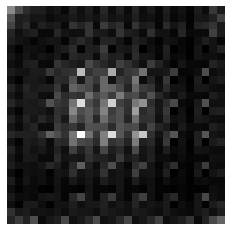

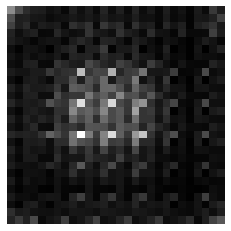

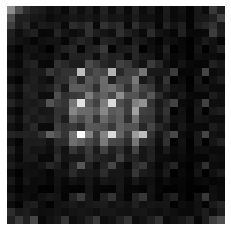

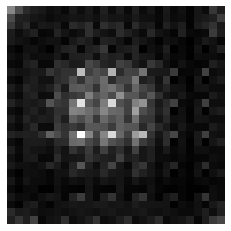

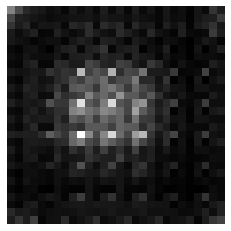

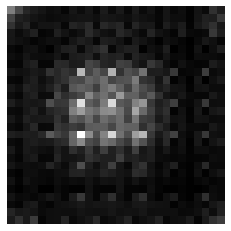

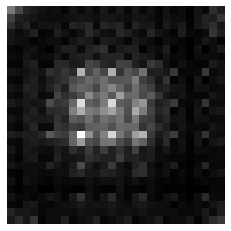

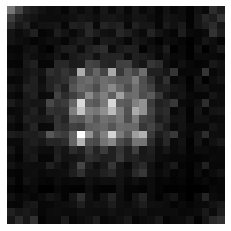

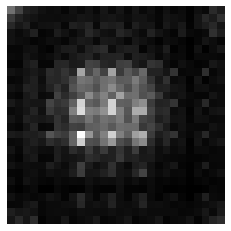

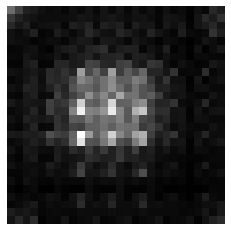

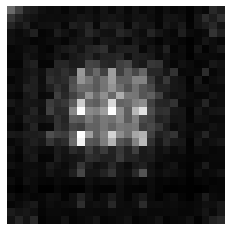

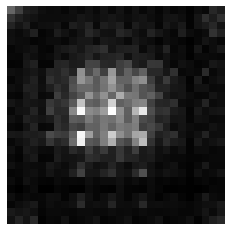

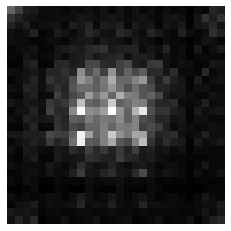

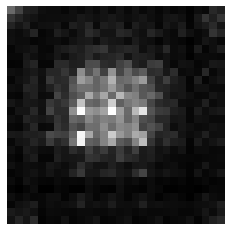

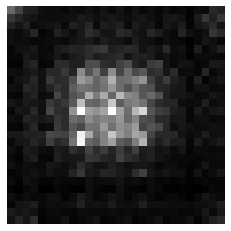

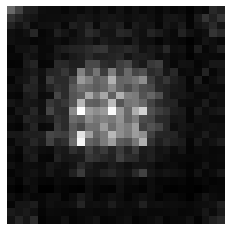

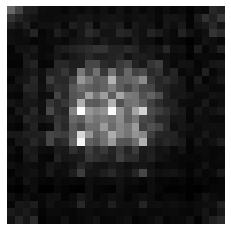

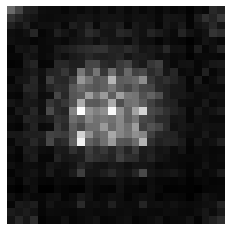

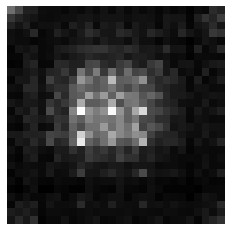

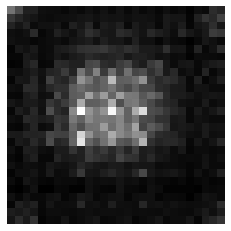

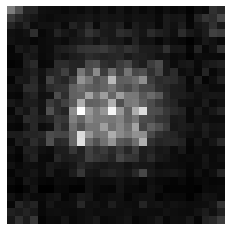

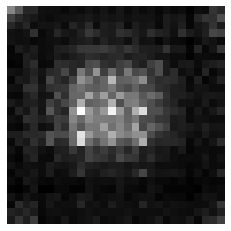

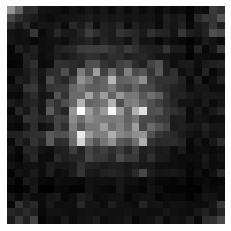

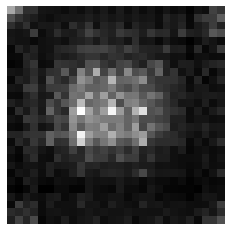

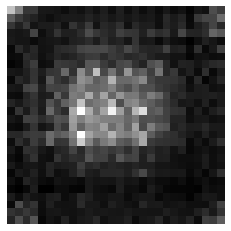

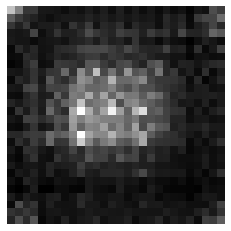

In [41]:
%%time
train(train_dataset, EPOCHS)

In [44]:
# 创建 GIF
# 使用 epoch 数生成单张图片
def display_image(epoch_no):
  return PIL.Image.open('./{:04d}.png'.format(epoch_no))

display_image(EPOCHS)

# 使用训练过程中生成的图片通过imageio生成动态gif
anim_file = 'dcgan.gif'
with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('./*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

<ipython-input-44-546d8514b207>:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-44-546d8514b207>:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
